In [52]:
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams['axes.grid'] = True

from scipy import signal


## Signal processing and calculations


In [41]:
class TTS:
    """
    The TTS class receives a stub filename, and looks for all files in the data folder that start with this stubname.
    """
    def __init__(self, subj, axes = 'ML'):        
        if axes == 'ML':
            axes = 'y'
        elif axes == 'AP':
            axes = 'x'
        self.subj = subj+"-"
        
        # look for all files in the data folder that starts with the subject's stubname.
        self.files = [c for c in listdir('data/') if self.subj in c]
        data = [self.ReadFile(f'data/{f}', axes) for f in self.files]
        self.x = [d[0] for d in data]
        self.y = [d[1] for d in data]
        
        # Then, the signal is calculated using all five approaches.
        self.y_TOP = [self.TOP(x, y) for x, y in zip(self.x, self.y)]
        self.y_SA = [self.SA(y) for y in self.y]
        self.y_RMS = [self.RMS(y) for y in self.y]
        self.y_CWT = [self.CWT(y) for y in self.y]
        self.y_CWT = [y / y.max() for y in self.y_CWT]
        
        # calculate 1sd of all files from the subject
        m = np.max([len(c) for c in self.y])
        f = np.vstack([np.pad(c, (0, m - len(c))) for c in self.y])
        f = np.mean(f, axis = 0)
        self.sd = self.CalculateThreshold(f)
        

    def ReadFile(self, file, axes = 'y'): 
        """
        A method for reading Kistler output files.
        This method reads the file, removes all data prior to subject's landing, filtering, rectifying and normalizing the signal.
        
        """
    #     This line reads the exact Kistler txt outputs. 
    #     The Z-axis is used to find the landing instance
        data = pd.read_csv(file, sep = '\t', skiprows = 11).drop(0)[['abs time (s)', f'F{axes}', 'Fz']].astype(float)
        data.columns = ['time',axes,'z']
        data.set_index('time', inplace = True)
        data['z'] -= data['z'].min()

        # landing occurs when the Z-axis goes over a threshold (just above zero)
        landing = np.where(data['z'].abs() > 20)[0].min()
        landing = data.index[landing]

        # remove anything earlier than landing, and reset indeces.
        data = data.loc[landing: landing + 15]  
        data.index -= landing

        # filter using a 2nd order Butterworth low-pass with a cut of freq. of 12Hz. 
        self.fs = data.index.argmax() / data.index.max() # the Kistler sampling frequency
        sos = signal.butter(2, 12, 'low', output = 'sos', fs = self.fs)
        data[axes] = signal.sosfilt(sos, data[axes].values)

        # normalize data - set all values between 0 and 1
        data[axes] = np.abs(data[axes]) / np.abs(data[axes]).max()

        return data.index.values, data[axes].values
    
    def CalculateThreshold(self, y, w = 5): 
        """
        calculate the threshold as the minimal SD in a w consecutive seconds
        """
        w = int(self.fs * w)
        return np.min([y[i:i+w].std() for i in range(len(y)-w)])
        
    def RAW(self, y):
        """
        This method doesn't do anything, and returns the RAW values.
        """
        return y

    def RMS(self, y, window = 0.25, center = True):
        """
        Calculates the moving RMS with window size (number of samples, integer).
        center: boolean, if True pads the beginning and the end of the result vector with zeros. 
                Else, pads only the end.
        """
        window = int(self.fs * window)
        if center:
            w = window // 2
            return np.array([np.nan] * w + 
                            [np.sqrt(np.mean(y[i - w : i + w] ** 2)) for i in range(w, len(y) - w)] + 
                            [np.nan] * w)
        else:
            w = window
            return np.array(
                            [np.sqrt(np.mean(y[i : i + w] ** 2)) for i in range(len(y) - w)] + 
                            [np.nan] * w)

    def SA(self, y):
        """
        Calculate the sequential average signal
        """
        return np.array([np.mean(y[:i]) for i in range(1,len(y)+1)])


    def TOP(self, x, y):
        """
        Fit a Third-Order Polynomial
        """
        s = np.argmax(y)
        objective = lambda x, a, b, c, d: (a * x**3) + (b * x**2) + (c * x) + d
        a, b, c, d = np.polyfit(x = x[s:] - x[s:].min(), 
                                y = y[s:],
                                deg = 3)
        top = objective(x, a, b, c, d)
        return top

    def CWT(self, y, window = 100):
        """
        Calculates the continuous wavelet transform and integrate it to find the energy.
        """
        wv = signal.cwt(y, signal.morlet, np.arange(1, window), dtype = np.complex128)
        energy = np.trapz(wv, axis = 0)
        return np.abs(energy)
    
    def CalculateTTS(self, y, SD, duration = 0.5):
        threshold = self.sd * SD
        duration = int(duration * self.fs)
        
        # find when the signal goes below the threshold for at least 0.5 seconds (100 data samples)        
        for i in range(len(y) - int(duration)):
            if np.all(y[i : i+duration] < threshold):
                return i / self.fs if i / self.fs != 0 else np.nan
        return np.nan
    

def AbsAverage(filename, start = 0, window = 0.4):
    """
    A method to calculate the average absolute force between start and start+window in the ML (y) axis
    """
    data = pd.read_csv(f'data/{filename}', sep = '\t', skiprows = 11).drop(0).astype(float)[['abs time (s)', 'Fz', 'Fy']]
    data.columns = ['time','z', 'y']
    data.set_index('time', inplace = True)
    
    fs = data.index.argmax() / data.index.max() # the Kistler sampling frequency
    sos = signal.butter(2, 12, 'low', output = 'sos', fs = fs)
    data['y'] = signal.sosfilt(sos, data['y'].values)
    data['z'] = signal.sosfilt(sos, data['z'].values)
        
    landing = data.index[np.where(data['z'] > 20)[0].min()]
    data = data.loc[landing:]
    data.index -= landing
    
    abs_avg = data.loc[start:start + window, 'y'].abs().mean()
    return abs_avg
    
    
def TTSv(file, threshold = 0.05, ax = 'z'):
    """
    A method to calculate the vertical TTS.
    """
    data = pd.read_csv(f'data/{file}', sep = '\t', skiprows = 11).drop(0).astype(float)[['abs time (s)', f'F{ax}']]
    data.columns = ['time',ax]
    data[ax] -= data[ax].min() # zero begining
    
    data.set_index('time', inplace = True)
    
    fs = data.index.argmax() / data.index.max() # the Kistler sampling frequency
    sos = signal.butter(2, 12, 'low', output = 'sos', fs = fs)
    data['z'] = signal.sosfilt(sos, data[ax].values)
        
    landing = data.index[np.where(data[ax] > 20)[0].min()]
    data = data.loc[landing:]
    data.index -= landing
    
    weight = data[ax].iloc[-1000:].mean()
    lb_weight = weight - threshold * weight
    ub_weight = weight + threshold * weight
    
    if (data.iloc[len(data)-1][ax] >= ub_weight) or (data.iloc[len(data)-1][ax] <= lb_weight):
        return np.nan
    
    for i in range(len(data)-2, 0, -1):
        if (data.iloc[i][ax] >= ub_weight) or (data.iloc[i][ax] <= lb_weight):
            return data, data.index[i], lb_weight, ub_weight
        
    
    

## Examples - TTSml

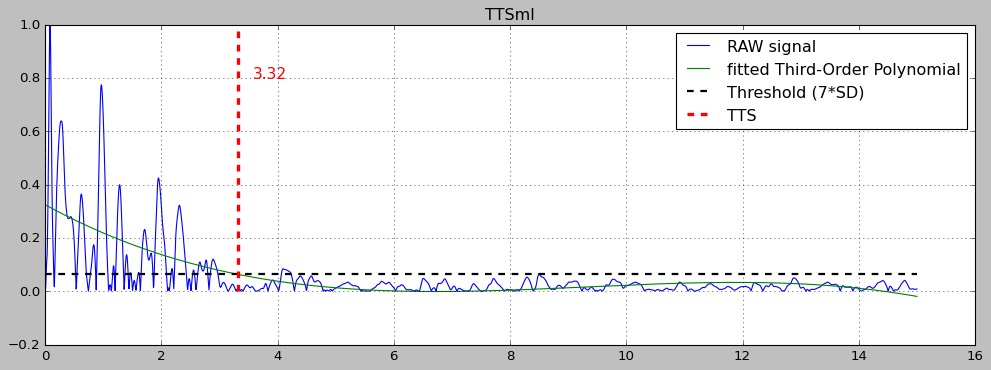

In [39]:
# read files starting with 'ex'
example = TTS('ex')

# plot RAW signal, and third-order polynomial signal
plt.plot(example.x[0], example.y[0], label = 'RAW signal')
plt.plot(example.x[0], example.y_TOP[0], label = 'fitted Third-Order Polynomial')

# plot the threshold (SD * 7, SD calculated over all jumps by the current subject.)
plt.hlines(example.sd * 7, 0, 15, color = 'black', ls = '--', lw = 2, label = 'Threshold (7*SD)')

# calculate TTS and plot
tts = example.CalculateTTS(example.y_TOP[0], 7, duration = 0.5)
plt.vlines(tts, 0, 1, color = 'red',  ls = '--', lw = 3, label = 'TTS')
plt.text(tts+0.25, 0.8, tts, color = 'red', fontsize = 14)

plt.title('TTSml')
plt.legend();

## Examples - TTSv

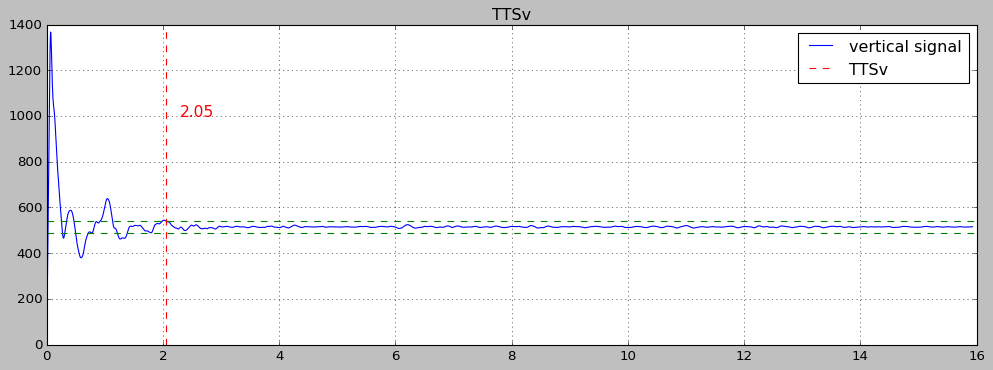

In [49]:
###### Calculate TTSv and lower & upper stability limits (as 5% of body weight)
data, ttsv, lb, ub = TTSv('ex-1.txt', threshold = 0.05)

plt.plot(data['z'], label = 'vertical signal')
plt.hlines(lb, 0, 16, ls = '--', color = 'green')
plt.hlines(ub, 0, 16, ls = '--', color = 'green')
plt.vlines(ttsv, plt.ylim()[0], plt.ylim()[1], color = 'red', ls = '--', label = 'TTSv')
plt.text(ttsv+0.25, 1000, ttsv, color = 'red', fontsize = 14)


plt.legend()
plt.title('TTSv');

## Examples - AbsAverage

In [51]:
# this method only returns the average absolute ML forces between start and start+window. 
# in this example, between 1 and 2 seconds.
AbsAverage('ex-1.txt', start = 1 , window = 1)

15.271004221069926